# Quality estimation of alignments

## 0.1 Load results

In [1]:
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"

In [2]:
import os
import sys
sys.path.append("..")

import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.eval.SampleResult import SampleResult

In [3]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

samples = [SampleResult.load_by_id(RESULT_DIR, file_id) for file_id in file_ids]

/Users/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:158: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/3575-170457-0000/3575-170457-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")
/Users/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:158: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/7127-75947-0000/7127-75947-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")


## 0.2 Processing Alginments

In [4]:
from tqdm import tqdm
from joblib import Parallel, delayed

In [5]:
metrics_df = pd.DataFrame()

In [6]:
def unaligned_partial_words(sample: SampleResult) -> int:
    unalignments = [len(alignements.unalignments) for alignements in sample.alignments]
    return sum(unalignments)

In [7]:
ALIGNMENT_SEQUENCES = ["final", "mfa", "baseline"]
TEMPORAL_ALIGNMENT_TOLERANCES = [0.0, 0.1, 0.5, 2.0]
# TEMPORAL_ALIGNMENT_TOLERANCES = list(map(lambda x: x/100, range(0, 21, 2)))

In [8]:
for ALIGNMENT_SEQUENCE in ALIGNMENT_SEQUENCES:
    print(f"Evaluating with {ALIGNMENT_SEQUENCE} alignments")
    for TEMPORAL_ALIGNMENT_TOLERANCE in tqdm(TEMPORAL_ALIGNMENT_TOLERANCES):
        def process_sample(sample: SampleResult):
            try:
                sample.build_alignments(
                    normalize_words=True,
                    align_to=ALIGNMENT_SEQUENCE,
                    temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE
                )
                sample.word_first_corrects()
                sample.word_first_finals()
                return sample
            except Exception as e:
                print(f"Error processing sample {sample.sample_id} with {ALIGNMENT_SEQUENCE} alignment and "
                    f"{TEMPORAL_ALIGNMENT_TOLERANCE} tolerance: {e}")

        processed_samples = Parallel(n_jobs=-1)(delayed(process_sample)(s) for s in samples)
        
        eval = pd.Series()
        eval["alignment_sequence"] = ALIGNMENT_SEQUENCE
        eval["temporal_alignment_tolerance"] = TEMPORAL_ALIGNMENT_TOLERANCE
        eval["alignments"] = [s.alignments for s in processed_samples]

        eval["control_sequence_length"] = sum([len(s._alignment_sequence) for s in processed_samples])
        eval["unaligned_partial_words"] = sum([unaligned_partial_words(s) for s in processed_samples])

        total_wfc = np.concat([s.wfc for s in processed_samples])
        eval["wfc_latency"] = np.array([r["latency"] for r in total_wfc if r is not None])
        eval["wfc_none_count"] = len(total_wfc) - len(eval["wfc_latency"])

        total_wff = np.concat([s.wff for s in processed_samples])
        eval["wff_latency"] = np.array([r["latency"] for r in total_wff if r is not None])
        eval["wff_none_count"] = len(total_wff) - len(eval["wff_latency"])

        metrics_df = pd.concat([metrics_df, eval.to_frame().T], ignore_index=True)

metrics_df.sort_values(by=["alignment_sequence", "temporal_alignment_tolerance"], inplace=True)
metrics_df.info()


Evaluating with final alignments


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:55<00:00, 13.87s/it]


Evaluating with mfa alignments


100%|██████████| 4/4 [01:13<00:00, 18.46s/it]


Evaluating with baseline alignments


100%|██████████| 4/4 [01:21<00:00, 20.43s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 8 to 7
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   alignment_sequence            12 non-null     object
 1   temporal_alignment_tolerance  12 non-null     object
 2   alignments                    12 non-null     object
 3   control_sequence_length       12 non-null     object
 4   unaligned_partial_words       12 non-null     object
 5   wfc_latency                   12 non-null     object
 6   wfc_none_count                12 non-null     object
 7   wff_latency                   12 non-null     object
 8   wff_none_count                12 non-null     object
dtypes: object(9)
memory usage: 960.0+ bytes


In [9]:
metrics_df["accepted_alignments_count"] = metrics_df["alignments"].apply(lambda x: sum([sum([len(a.accepted_alignments) for a in p]) for p in x]))
metrics_df["confirmed_alignments_count"] = metrics_df["alignments"].apply(lambda x: sum([sum([len(a.confirmed_alignments) for a in p]) for p in x]))
metrics_df["accepted_alignments_ratio"] = metrics_df["accepted_alignments_count"] / metrics_df["confirmed_alignments_count"]
metrics_df["confirmed_potential_alignments_count"] = metrics_df.apply(lambda x: x["confirmed_alignments_count"] - x["accepted_alignments_count"], axis=1)
metrics_df["unaligned_partial_words_percentage"] = metrics_df["unaligned_partial_words"] / (metrics_df["unaligned_partial_words"] + metrics_df["confirmed_alignments_count"])

metrics_df["wfc_none_percentage"] = metrics_df["wfc_none_count"] / metrics_df["control_sequence_length"]
metrics_df["wfc_latency_min"] = metrics_df["wfc_latency"].apply(lambda x: np.min(x) if len(x) > 0 else None)
metrics_df["wfc_latency_max"] = metrics_df["wfc_latency"].apply(lambda x: np.max(x) if len(x) > 0 else None)
metrics_df["wfc_latency_mean"] = metrics_df["wfc_latency"].apply(lambda x: np.mean(x) if len(x) > 0 else None)
metrics_df["wfc_latency_mean_excl_neg"] = metrics_df["wfc_latency"].apply(lambda x: np.mean([i for i in x if i >= 0]) if len(x) > 0 else None)
metrics_df["wfc_latency_std"] = metrics_df["wfc_latency"].apply(lambda x: np.std(x) if len(x) > 0 else None)
metrics_df["wfc_latency_median"] = metrics_df["wfc_latency"].apply(lambda x: np.median(x) if len(x) > 0 else None)
metrics_df["wfc_latency_negative_count"] = metrics_df["wfc_latency"].apply(lambda x: len([i for i in x if i < 0]) if len(x) > 0 else None)
metrics_df["wfc_latency_p95"] = metrics_df["wfc_latency"].apply(lambda x: np.percentile(x, 95) if len(x) > 0 else None)
metrics_df["wfc_latency_p99"] = metrics_df["wfc_latency"].apply(lambda x: np.percentile(x, 99) if len(x) > 0 else None)

metrics_df["wff_latency_min"] = metrics_df["wff_latency"].apply(lambda x: np.min(x) if len(x) > 0 else None)
metrics_df["wff_latency_max"] = metrics_df["wff_latency"].apply(lambda x: np.max(x) if len(x) > 0 else None)
metrics_df["wff_latency_mean"] = metrics_df["wff_latency"].apply(lambda x: np.mean(x) if len(x) > 0 else None)
metrics_df["wff_latency_std"] = metrics_df["wff_latency"].apply(lambda x: np.std(x) if len(x) > 0 else None)
metrics_df["wff_latency_median"] = metrics_df["wff_latency"].apply(lambda x: np.median(x) if len(x) > 0 else None)
metrics_df["wff_latency_negative_count"] = metrics_df["wff_latency"].apply(lambda x: len([i for i in x if i < 0]) if len(x) > 0 else None)
metrics_df["wff_latency_p95"] = metrics_df["wff_latency"].apply(lambda x: np.percentile(x, 95) if len(x) > 0 else None)
metrics_df["wff_latency_p99"] = metrics_df["wff_latency"].apply(lambda x: np.percentile(x, 99) if len(x) > 0 else None)

baseline_df = metrics_df[metrics_df["alignment_sequence"] == "baseline"]
final_df = metrics_df[metrics_df["alignment_sequence"] == "final"]
mfa_df = metrics_df[metrics_df["alignment_sequence"] == "mfa"]

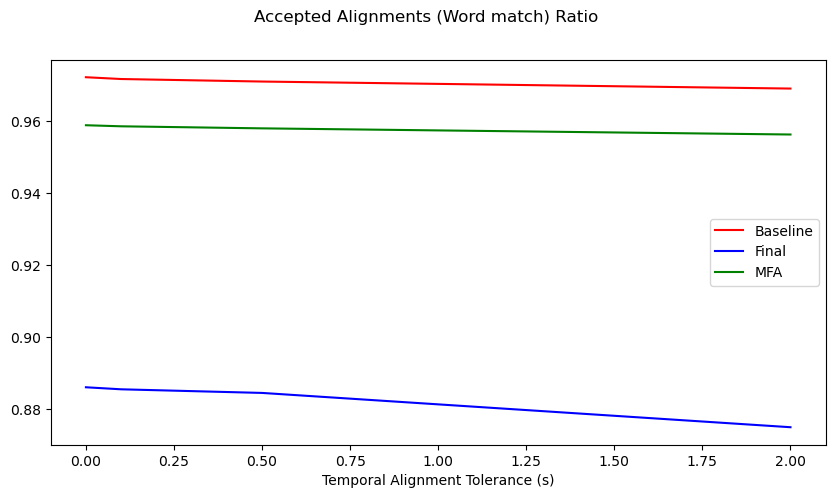

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Accepted Alignments (Word match) Ratio")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
# ax.set_xscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["accepted_alignments_ratio"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["accepted_alignments_ratio"], color="blue")
ax.plot(mfa_df["temporal_alignment_tolerance"], mfa_df["accepted_alignments_ratio"], color="green")
ax.legend(["Baseline", "Final", "MFA"])

plt.show()

## 1.1 Unaligned Words

### Unaligned *control* words

Unaligned control words are words, for which no correct prediction has been made. Speaking in terms of alignment, for every prediction timestep, no word has been aligned *acceptedly* to that specific word.

The implication of this is, that there was not a single prediction, that recognized this control word correctly.

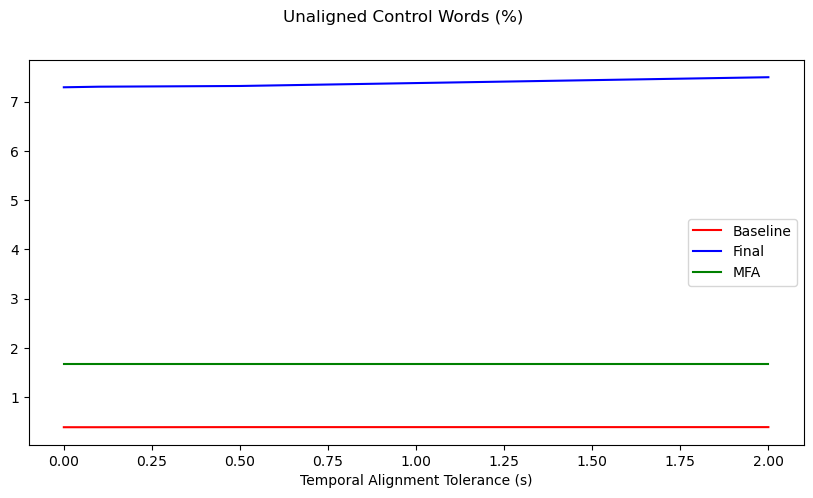

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Unaligned Control Words (%)")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["wfc_none_percentage"] * 100, color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["wfc_none_percentage"] * 100, color="blue")
ax.plot(mfa_df["temporal_alignment_tolerance"], mfa_df["wfc_none_percentage"] * 100, color="green")
ax.legend(["Baseline", "Final", "MFA"])

plt.show()

### Unaligend *partial* words

Partial words are unaligned, if they cannot be aligned to a word of the control sequence.

One of two cases might be possible:

1. There is no word with temporal overlap in the control sequence
2. The word(s) with temporal overlap has been consumed by another alignment

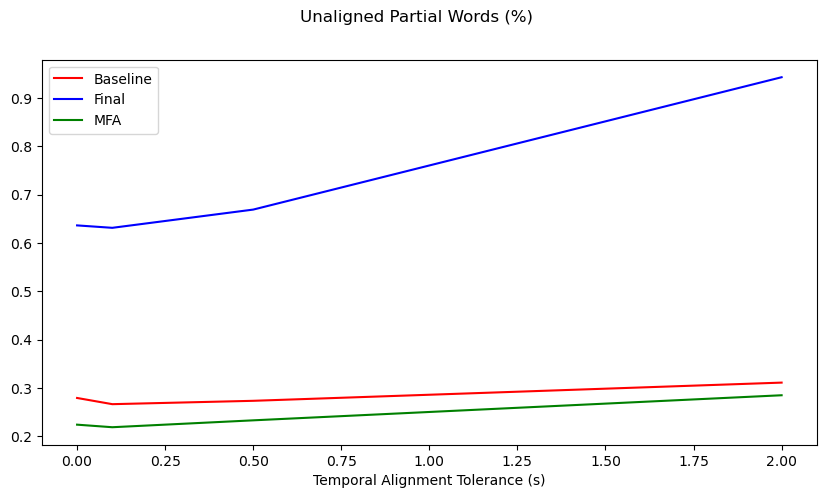

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Unaligned Partial Words (%)")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
# ax.set_xscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["unaligned_partial_words_percentage"] * 100, color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["unaligned_partial_words_percentage"] * 100, color="blue")
ax.plot(mfa_df["temporal_alignment_tolerance"], mfa_df["unaligned_partial_words_percentage"] * 100, color="green")
ax.legend(["Baseline", "Final", "MFA"])

plt.show()

This gap in unaligned partial words with the final control sequence and its instability indicates problematic behaviour when trying to align partial prediction words to their position in the final transcript. This is particularly interessting, because one migth expect the final transcript to be more or less a concatination of the partial predictions. Therefore unaligned partial words hint to some faulty behaviour related to the generation process of the final transcript.

In fact such behaviour can be observed by looking at some examples of the final sequence, partial predictions, and their alignment:

![](../img/2025-06-03_faulty_final_alignment.png)

In this example, somehow the predicted partial words *"who had from this moment become"* did not end up in the final transcript and the words "the king" are output with unseen timings.

Given this information let's compare the total legth of the control sequences.

## 1.2 Size of control sequence

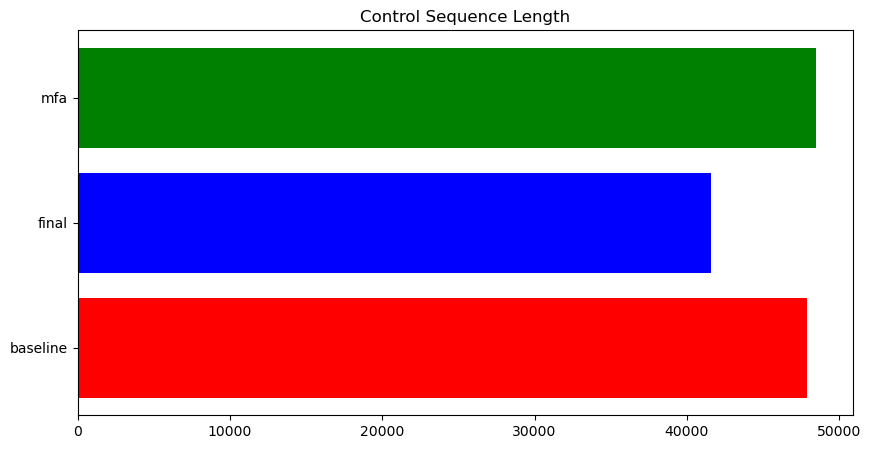

In [13]:
cs_length_df = metrics_df.groupby(["alignment_sequence"]).agg({
    "control_sequence_length": "mean"
}).reset_index()
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(cs_length_df["alignment_sequence"], cs_length_df["control_sequence_length"], color=["red", "blue", "green"])
ax.set_title("Control Sequence Length")

plt.show()

This dip in size of the control sequence further confirms the hypothesis of missing words in the final transcript.

## 1.3 Distribution of alignment types

In [ ]:
temporal_tolerance = 0.0

compare_metrics_df = metrics_df[metrics_df["temporal_alignment_tolerance"] == temporal_tolerance]

control_sequences = compare_metrics_df["alignment_sequence"].unique()

unaligned = []
confirmed = []
accepted = []
total = []

for control_sequence in control_sequences:
    seq_df = compare_metrics_df[compare_metrics_df["alignment_sequence"] == control_sequence]
    row = seq_df.iloc[0]

    unaligned.append(row["unaligned_partial_words"])
    confirmed.append(row["confirmed_potential_alignments_count"])
    accepted.append(row["accepted_alignments_count"])
    total.append(row["unaligned_partial_words"] + row["confirmed_potential_alignments_count"] + row["accepted_alignments_count"])

import numpy as np
x = np.arange(len(control_sequences))

Baseline: 96.96% accepted, 2.76% confirmed, 0.28% unaligned
   Final: 88.04% accepted, 11.33% confirmed, 0.64% unaligned
     MFA: 95.68% accepted, 4.10% confirmed, 0.22% unaligned


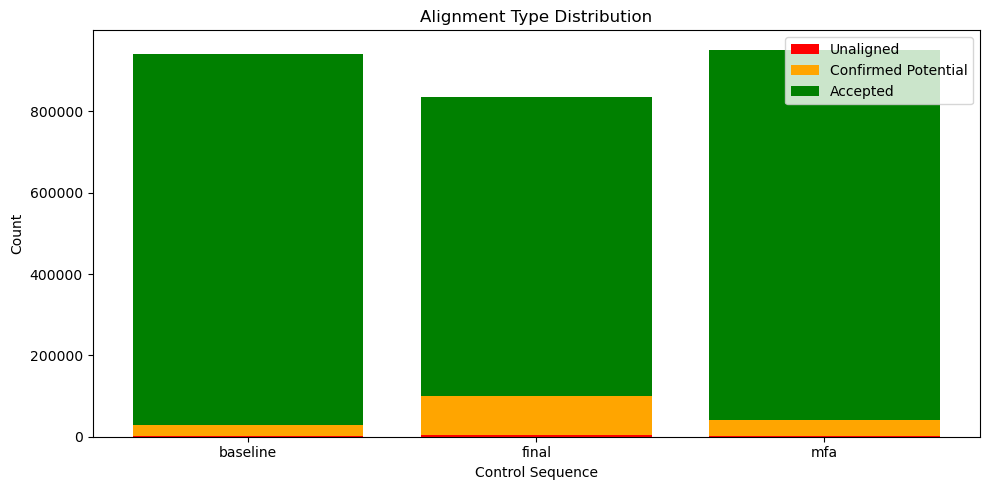

In [15]:
print(f"Baseline: {accepted[0] / total[0] * 100:.2f}% accepted, "
      f"{confirmed[0] / total[0] * 100:.2f}% confirmed, "
      f"{unaligned[0] / total[0] * 100:.2f}% unaligned")
print(f"   Final: {accepted[1] / total[1] * 100:.2f}% accepted, "
      f"{confirmed[1] / total[1] * 100:.2f}% confirmed, "
      f"{unaligned[1] / total[1] * 100:.2f}% unaligned")
print(f"     MFA: {accepted[2] / total[2] * 100:.2f}% accepted, "
      f"{confirmed[2] / total[2] * 100:.2f}% confirmed, "
      f"{unaligned[2] / total[2] * 100:.2f}% unaligned")

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, unaligned, label="Unaligned", color="red")
ax.bar(x, confirmed, label="Confirmed Potential", color="orange", bottom=unaligned)
ax.bar(x, accepted, label="Accepted", color="green", bottom=np.array(unaligned) + np.array(confirmed))

# ax.set_ylim(100, 150000)
ax.set_xticks(x)
ax.set_xticklabels(control_sequences)
ax.set_xlabel("Control Sequence")
ax.set_ylabel("Count")
ax.set_title("Alignment Type Distribution")
ax.legend()
fig.tight_layout()
